In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import requests
import pandas as pd
import numpy as np
import os
import pytz

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from backtrader.utils.py3 import with_metaclass

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from datetime import date
from bs4 import BeautifulSoup 

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": "2330",
    "start_date": "2021-03-01",
    "token": "", # 參考登入，獲取金鑰
}
data0 = requests.get(url, params=parameter)
data0 = data0.json()
data0 = pd.DataFrame(data0['data'])
data0['date'] = pd.to_datetime(data0['date'], format='%Y-%m-%d', errors='ignore')
#map to backtrader df.column reserved key
data0 = data0.rename(columns={'date': 'datetime', 'open': 'open', 'max': 'high', 'min': 'low', 'close': 'close', 'Trading_Volume': 'volume'})
data0 = data0[['datetime', 'open', 'high', 'low', 'close', 'volume']]
data0.index = data0['datetime']
data0.head()
#data0.dtypes

,datetime,open,high,low,close,volume
datetime,,,,,,
2021-03-02,2021-03-02,621.0,622.0,609.0,609.0,57792973
2021-03-03,2021-03-03,609.0,622.0,601.0,622.0,61171387
2021-03-04,2021-03-04,609.0,611.0,601.0,601.0,75508388
2021-03-05,2021-03-05,588.0,605.0,584.0,601.0,85579527
2021-03-08,2021-03-08,608.0,610.0,598.0,598.0,47676630


In [3]:
#融資融劵表 TaiwanStockMarginPurchaseShortSale
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockMarginPurchaseShortSale",
    "data_id": "2330",
    "start_date": "2021-03-01",
    "token": "", # 參考登入，獲取金鑰
}
data1 = requests.get(url, params=parameter)
data1 = data1.json()
data1 = pd.DataFrame(data1['data'])
data1['date'] = pd.to_datetime(data1['date'], format='%Y-%m-%d', errors='ignore')
# map to extend customer df.column key
data1 = data1.rename(columns={'date': 'datetime', 'MarginPurchaseTodayBalance': 'MagPurchBalance', 'ShortSaleTodayBalance': 'ShortSaleBalance'})
data1 = data1[['datetime', 'MagPurchBalance', 'ShortSaleBalance']]
data1.index = data1['datetime']
data1.head()

,datetime,MagPurchBalance,ShortSaleBalance
datetime,,,
2021-03-02,2021-03-02,34840,707
2021-03-03,2021-03-03,35436,661
2021-03-04,2021-03-04,36603,519
2021-03-05,2021-03-05,37639,578
2021-03-08,2021-03-08,37322,491


In [4]:
frames = [data0, data1]
data = pd.concat(frames, axis=1)
data.head()

,datetime,open,high,low,close,volume,datetime,MagPurchBalance,ShortSaleBalance
datetime,,,,,,,,,
2021-03-02,2021-03-02,621.0,622.0,609.0,609.0,57792973,2021-03-02,34840,707
2021-03-03,2021-03-03,609.0,622.0,601.0,622.0,61171387,2021-03-03,35436,661
2021-03-04,2021-03-04,609.0,611.0,601.0,601.0,75508388,2021-03-04,36603,519
2021-03-05,2021-03-05,588.0,605.0,584.0,601.0,85579527,2021-03-05,37639,578
2021-03-08,2021-03-08,608.0,610.0,598.0,598.0,47676630,2021-03-08,37322,491


In [5]:
# extend df.column from tsfresh feature extract and select
# attach at end of column
class PdStockMarginPurchaseShortSale(btfeeds.PandasData):

    lines = ('MagPurchBalance', 'ShortSaleBalance')
    params = (('MagPurchBalance', -1),
              ('ShortSaleBalance', -1))

    if False:
        # No longer needed with version 1.9.62.122
        datafields = btfeeds.PandasData.datafields + (
            ['MagPurchBalance', 'ShortSaleBalance'])
                

class SessionFilter(object):
    def __init__(self, data):
        pass

    def __call__(self, data):
        if data.p.sessionstart <= data.datetime.time() <= data.p.sessionend:
            # bar is in the session
            return False  # tell outer data loop the bar can be processed

        # bar outside of the regular session times
        data.backwards()  # remove bar from data stack
        return True  # tell outer data loop to fetch a new bar        

    
class CloseMinMaxFilter(with_metaclass(bt.metabase.MetaParams, object)):
    
    params = (('Min', 60),
              ('Max', 100))
    
    def __init__(self, data):
        pass

    def __call__(self, data):
        if data.close[0] >= self.p.Min and data.close[0] <= self.p.Max: 
            print('F %f <= %f <= %f' % (
                self.p.Min,
                data.close[0],
                self.p.Max
            ))
            return False         
        return True
    
    
class StrategyOptix(bt.Strategy):

    params = dict(
        period=15,
        stake=10,
        printout=True,
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None

        # Create SMA on 2nd data
        sma = btind.MovAv.SMA(self.data1, period=self.p.period)
        # Create a CrossOver Signal from close an moving average
        self.signal = btind.CrossOver(self.data1.close, sma)

    def next(self):
        if self.orderid:
            return  # if an order is active, no new orders are allowed

        if self.p.printout:
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 len == Data1 len:',
                  len(self.data0) == len(self.data1))

            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())

        if not self.position:  # not yet in market
            if self.signal > 0.0:  # cross upwards
                self.log('BUY CREATE , %.2f' % self.data1.close[0])
                self.buy(size=self.p.stake)
                self.buy(data=self.data1, size=self.p.stake)

        else:  # in the market
            if self.signal < 0.0:  # crosss downwards
                self.log('SELL CREATE , %.2f' % self.data1.close[0])
                self.sell(size=self.p.stake)
                self.sell(data=self.data1, size=self.p.stake)

    def stop(self):
        print('==================================================')
        print('Starting Value - %.2f' % self.broker.startingcash)
        print('Ending   Value - %.2f' % self.broker.getvalue())
        print('==================================================')


Self  len: 16
Data0 len: 16
Data1 len: 16
Data0 len == Data1 len: True
Data0 dt: 2021-03-23 00:00:00
Data1 dt: 2021-03-23 00:00:00
Self  len: 17
Data0 len: 17
Data1 len: 17
Data0 len == Data1 len: True
Data0 dt: 2021-03-24 00:00:00
Data1 dt: 2021-03-24 00:00:00
Self  len: 18
Data0 len: 18
Data1 len: 18
Data0 len == Data1 len: True
Data0 dt: 2021-03-25 00:00:00
Data1 dt: 2021-03-25 00:00:00
Self  len: 19
Data0 len: 19
Data1 len: 19
Data0 len == Data1 len: True
Data0 dt: 2021-03-26 00:00:00
Data1 dt: 2021-03-26 00:00:00
Self  len: 20
Data0 len: 20
Data1 len: 20
Data0 len == Data1 len: True
Data0 dt: 2021-03-29 00:00:00
Data1 dt: 2021-03-29 00:00:00
2021-03-29T00:00:00, BUY CREATE , 599.00
2021-03-30T00:00:00, Margin ,
2021-03-30T00:00:00, BUY COMPLETE, 600.00
Self  len: 21
Data0 len: 21
Data1 len: 21
Data0 len == Data1 len: True
Data0 dt: 2021-03-30 00:00:00
Data1 dt: 2021-03-30 00:00:00
2021-03-30T00:00:00, SELL CREATE , 597.00
2021-03-31T00:00:00, SELL COMPLETE, 596.00
2021-03-31T00:00

<IPython.core.display.Javascript object>


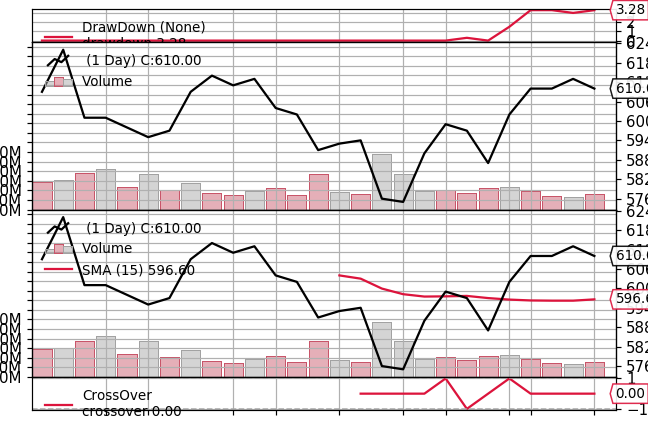

[[<Figure size 432x288 with 6 Axes>]]

In [12]:
tframes = dict(
        daily=bt.TimeFrame.Days,
        weekly=bt.TimeFrame.Weeks,
        monthly=bt.TimeFrame.Months)

cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_cash(10000)

cerebro.addstrategy(StrategyOptix)
data0 = PdStockMarginPurchaseShortSale(dataname=data)
data1 = PdStockMarginPurchaseShortSale(dataname=data)

# add lower/upper bound close val filter
#data0.addfilter(CloseMinMaxFilter)


# resample datetime period from daily sample to weekly sample
#cerebro.replaydata(data0,
#    timeframe=tframes['weekly'],
#    compression=1)
    
# add multi timeframe source in(input name is reserved)
cerebro.adddata(data0)
cerebro.adddata(data1)
cerebro.addobserver(bt.observers.DrawDown)

results = cerebro.run()

cerebro.plot()

In [ ]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
print('-- RETURNS')
print(returns)
print('-- POSITIONS')
print(positions)
print('-- TRANSACTIONS')
print(transactions)
print('-- GROSS LEVERAGE')
print(gross_lev)

import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    #gross_lev=gross_lev,
    live_start_date='2021-03-02',
    round_trips=True)